## Goal of notebook

This notebook accompanies [sSVN](https://github.com/leviyevalex/sSVN), and provides an example of how to run on the hybrid Rosenbrock. The hybrid Rosenbrock is a very convenient benchmark.
1. It is easily adapted to any number of dimensions $D \ge 2$.
2. Each marginal is a long and narrow ridge. These are notoriously difficult for sampling algorithms to resolve.
3. It may be analytically sampled, providing a computationally trivial way to compare the quality of samples obtained via various methods/algorithms.
4. Most importantly, it closely resembles many geometries often encountered in practice (e.g, https://arxiv.org/abs/2106.15163).

In this notebook we compare the performance of SVGD and sSVN on a ten-dimensional hybrid Rosenbrock. We encourage the reader to tinker with the settings of the hybrid Rosenbrock, `eps`, and `nParticles`. The reader will find that sSVN is much more stable than sSVGD. That is, sSVN may be evolved with a much larger `eps`.

## Import tools

In [1]:
import sys
sys.path.append("..")

from models.JAXHRD import hybrid_rosenbrock
from models.multivariate_gaussian import multivariate_gaussian
from src.samplers import samplers
from scripts.plot_helper_functions import collect_samples
import numpy as np
%matplotlib inline
import logging
import sys
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
import corner

In [ ]:
from jax import random
import jax.numpy as jnp
x = random.uniform(random.PRNGKey(0), (1000,), dtype=jnp.float64)
x.dtype






In [ ]:
2 / 2 ** 2

## Setup hybrid Rosenbrock model

In [ ]:
# Hybrid Rosenbrock
n2 = 3
n1 = 4
DoF = n2 * (n1 - 1) + 1
B = np.zeros(DoF)
B[0] = 30
B[1:] = 20
mu=1
model = hybrid_rosenbrock(n2, n1, mu, B)
ground_truth = model.newDrawFromPosterior(100000)

In [2]:
# Gaussian
DoF = 10
mu = np.zeros(DoF)
np.random.seed(1)
sigma = np.random.uniform(low=1, high=DoF, size=DoF) # covariance matrix
# sigma = np.ones(DoF) * 3
model = multivariate_gaussian(mu, sigma)
ground_truth_samples = model.newDrawFromLikelihood(10000000)

In [3]:
truth_table = ((ground_truth_samples > model.lower_bound) & (ground_truth_samples < model.upper_bound))
idx = np.where(np.all(truth_table, axis=1))[0]
# np.random.seed(2)
print('%i samples obtained from rejection sampling' % idx.shape[0])
bounded_iid_samples = ground_truth_samples[idx]

323782 samples obtained from rejection sampling


In [ ]:
bounded_iid_samples = np.load('gaussian_bound_samples.npy')

## Run sSVGD dynamics

Remark: sSVGD is unstable with eps=0.01. Try it!

In [4]:
nParticles = 100
nIterations = 500
# kernelKwargs = {'kernel_type': 'RBF', 'nFeatures':nParticles}
kernelKwargs = {'h':model.DoF / 10, 'p':1} # Lp
# kernelKwargs = {'h' : model.DoF / 10} # RBF
# kernelKwargs = {'h':model.DoF / 10, 'p':0.5} # Lp

# t = np.ones(nIterations) * 0.01
# t[int(nIterations / 2):] = 0.5
# t = np.linspace(0.1, 0.15, nIterations) # Sequence of smoothing parameters
# sampler1 = samplers(model=model, nIterations=nIterations, nParticles=nParticles, profile=False, kernel_type='Lp', bounded='log_boundary', t=t)
sampler1 = samplers(model=model, nIterations=nIterations, nParticles=nParticles, profile=False, kernel_type='Lp')
sampler1.apply(method='mirrorSVGD', eps=1, kernelKwargs=kernelKwargs)

Stepsize 1.000000 | Median bandwidth: 4.765338: 100%|██████████| 500/500 [03:43<00:00,  2.24it/s]


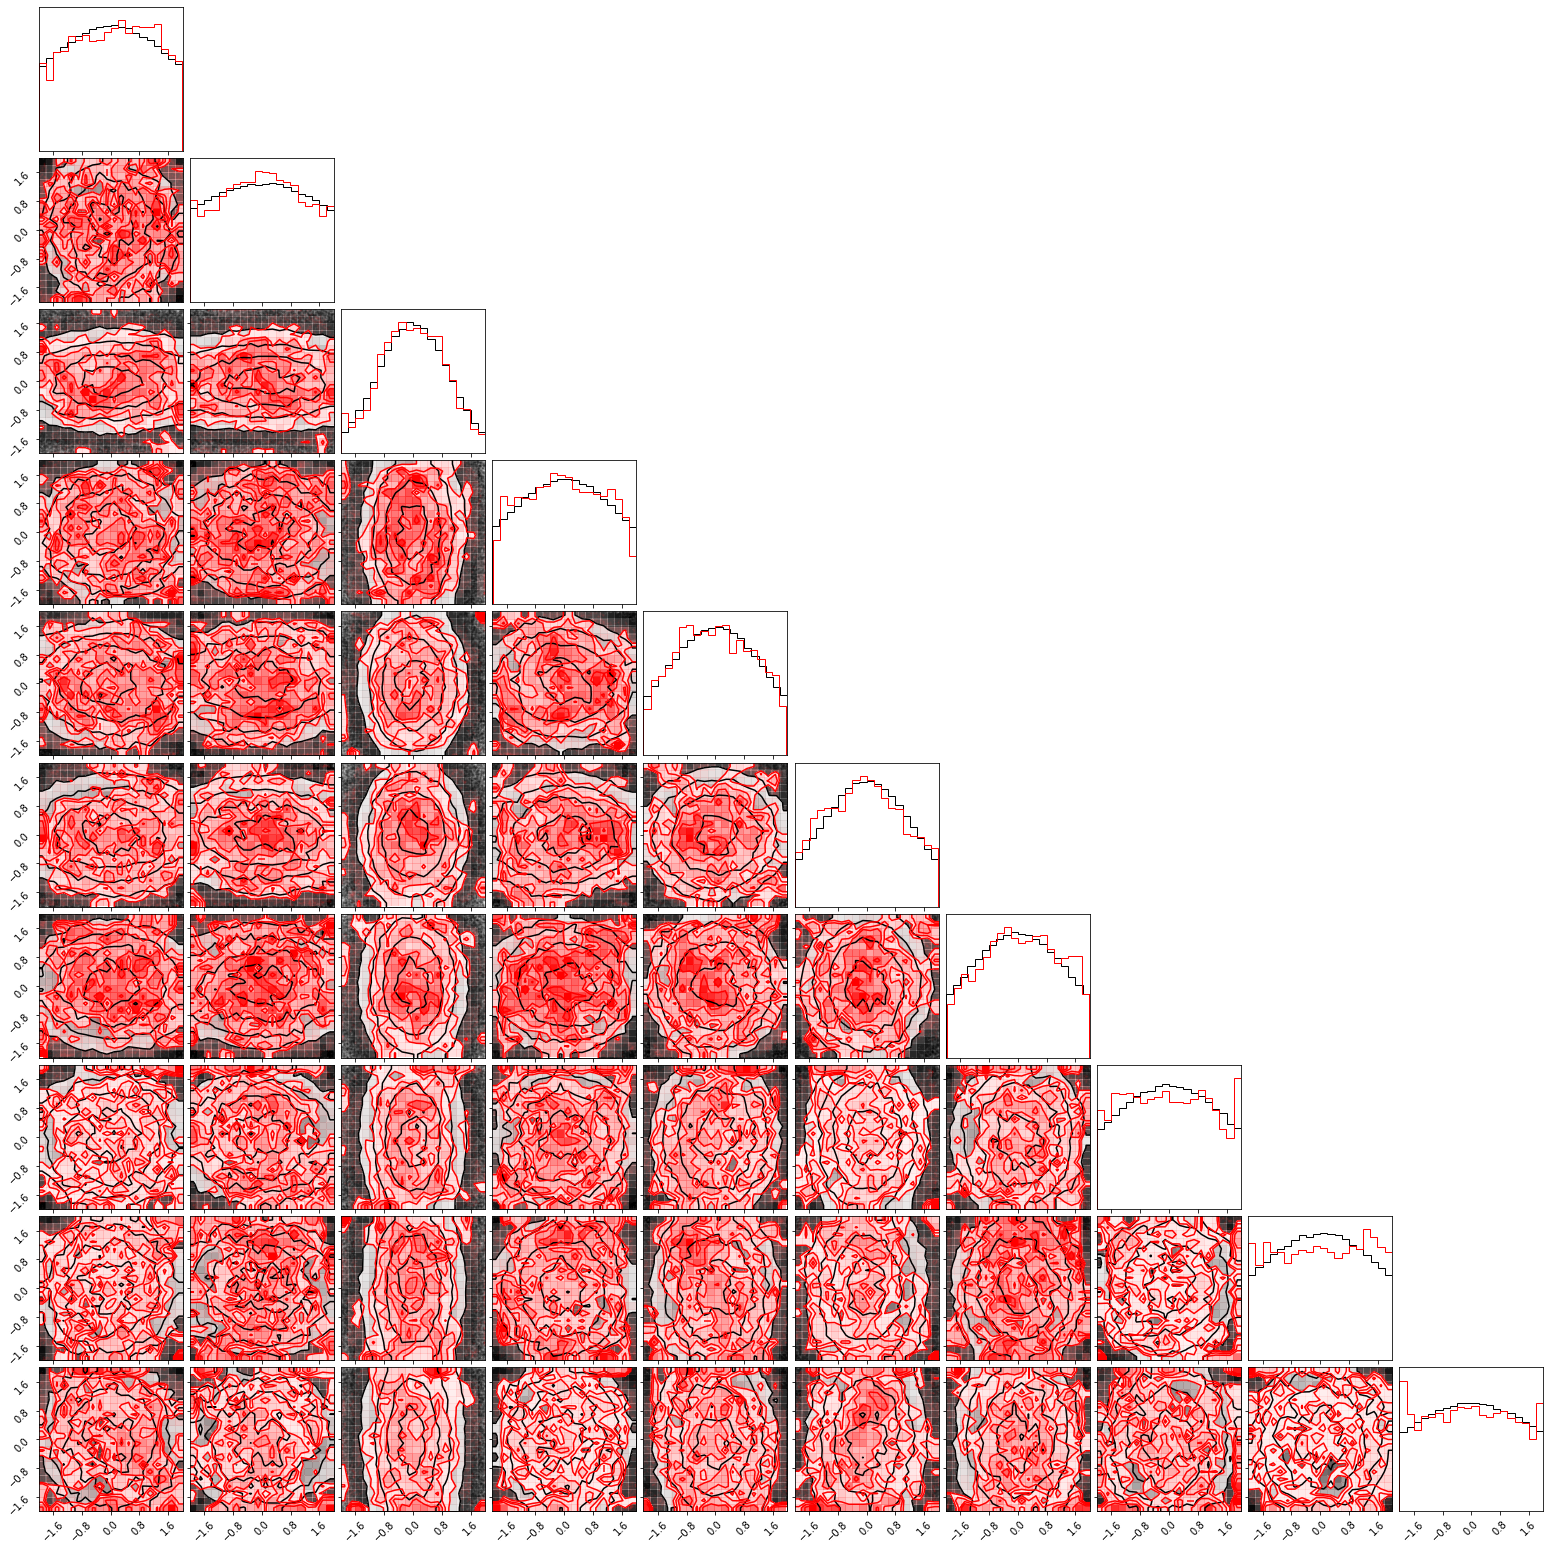

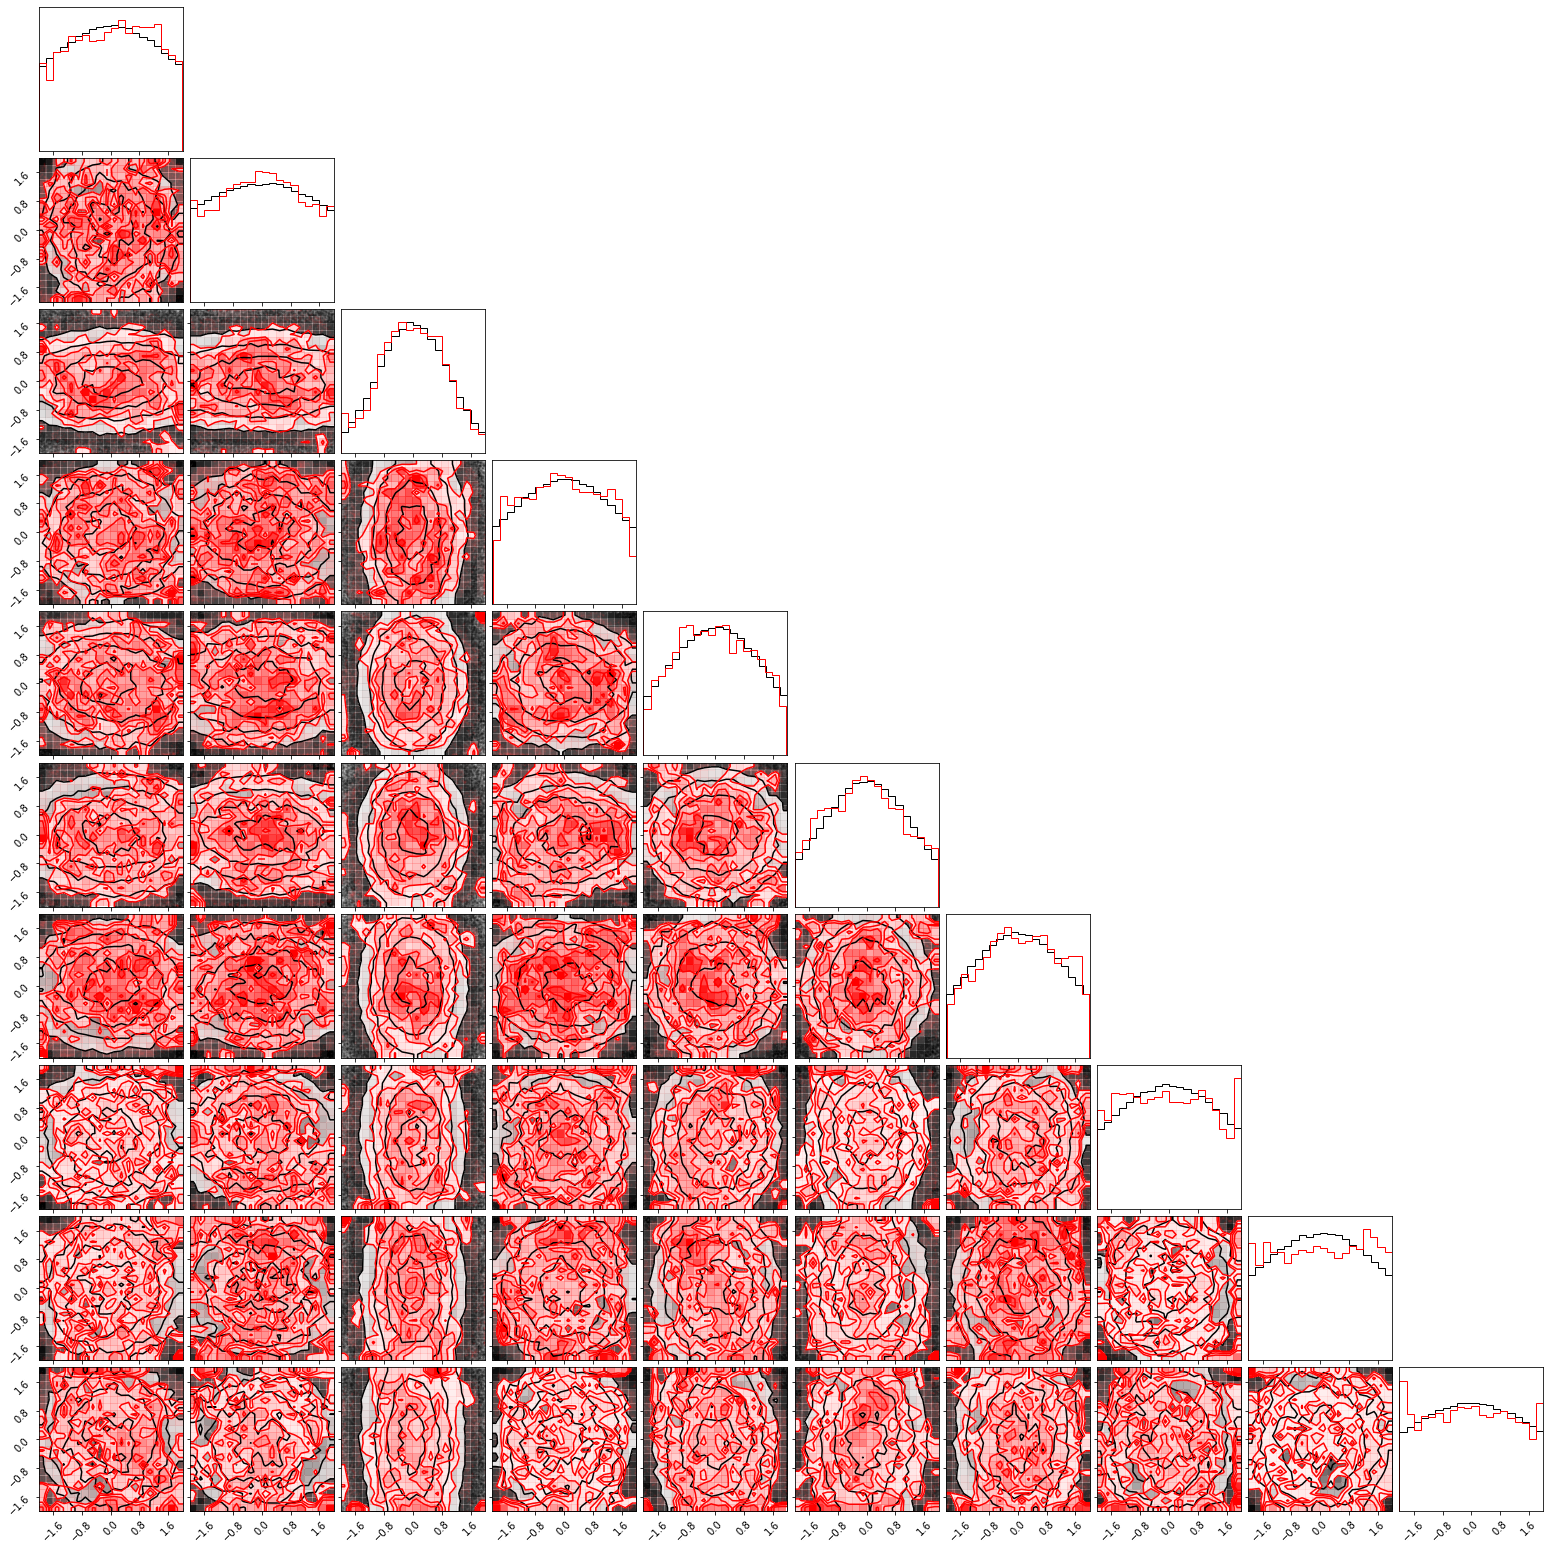

In [5]:
# %%capture
X1 = collect_samples(sampler1.history_path)
# fig1 = corner.corner(bounded_iid_samples[0:X1.shape[0]])
fig1 = corner.corner(bounded_iid_samples, hist_kwargs={'density':True})
# fig1 = corner.corner(ground_truth, hist_kwargs={'density':True})


# ground_truth=model.newDrawFromLikelihood(1000000)
# ground_truth_samples = model.newDrawFromLikelihood(1000000)
# fig1 = corner.corner(ground_truth_samples, hist_kwargs={'density':True})

corner.corner(X1, color='r', fig=fig1, hist_kwargs={'density':True})
# fig1.savefig('bounded_gaussian_test.png')

In [ ]:
fig1 = corner.corner(ground_truth_samples, hist_kwargs={'density':True})

corner.corner(X1, color='r', fig=fig1, hist_kwargs={'density':True})

In [ ]:
X1.shape[0]

## Run sSVN dynamics

In [ ]:
from scripts.plot_helper_functions import extract_velocity_norms, extract_gmlpt_norm
import matplotlib.pyplot as plt
norms = extract_velocity_norms(sampler1.history_path)
gmlpt_norm = extract_gmlpt_norm(sampler1.history_path)


In [ ]:
# Convergence criteria

fig, axs = plt.subplots(1, 3)
# axs[0].plot(model.fgrid, L1_response.squeeze())
axs[0].plot(norms['vsvn'])
axs[0].set_yscale('log')
axs[1].plot(norms['vsvgd'])
axs[1].set_yscale('log')
axs[2].plot(gmlpt_norm)
axs[2].set_yscale('log')







In [ ]:
plt.yscale('log')
plt.plot(norms['vsvn'])
plt.ylabel('Norm of SVGD vector')
plt.xlabel('Iteration')

# norms['vsvn']

In [ ]:
plt.yscale('log')
plt.plot(norms['v_svgd'])
plt.ylabel('Norm of SVGD vector')
plt.xlabel('Iteration')

In [ ]:
sampler2 = samplers(model=model, nIterations=100, nParticles=100, profile=False)
sampler2.apply(method='sSVN', eps=0.1)

In [ ]:
%%capture
X2 = collect_samples(sampler2.history_path)
fig2 = corner.corner(X2)

In [ ]:
corner.corner(ground_truth_samples[0:X2.shape[0]], fig=fig2)